# Lab07 - Region Segmentation
### TDS3651 Visual Information Processing


This lab will guide you on how to perform region segmentation on images from different perspectives. The simple method relies on colour information, where objects or regions can be segmented by clustering pixel values, a step higher than just thresholding. More powerful graph-based algorithms such as Felzenswalb's method and SLIC superpixels can also be used to segment regions using a variety of affinities between pixels such as brightness, color, textures, etc. In addition, to extend our current understanding of feature representations, we can now attempt to extract features from these segments (instead of individual pixels) to construct feature histograms, which can be used for matching images.

In addition to the typical libraries, we will use several libraries from [scikit-image](http://scikit-image.org/) package to enable us to perform segmentation with minimal coding overhead.

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans,vq

%matplotlib inline

## Recap: Segmentation by color
In the previous color processing lab, the HSV color space were used with a range thresholding to perform segmentation. However, it is noticeable that the segmentations are not perfect and it is challenging to determine the appropriate thresholds.

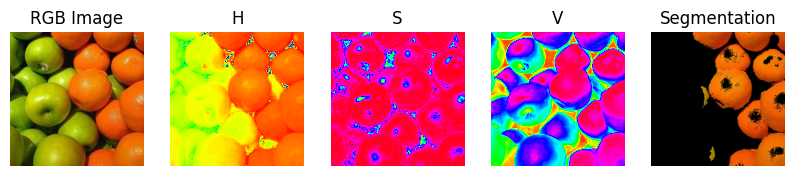

In [2]:
aao = cv2.imread('apples_oranges.jpg')
aao_hsv = cv2.cvtColor(aao, cv2.COLOR_BGR2HSV)

lowerhue = 0#5 # fill in
upperhue = 25#20 # fill in
lower_orange = np.array([lowerhue,225,150])
upper_orange = np.array([upperhue,255,255])
mask = cv2.inRange(aao_hsv, lower_orange, upper_orange)
res = cv2.bitwise_and(aao, aao, mask=mask)

fig, axs = plt.subplots(1, 5, figsize=(10,10))
channels = ['H', 'S', 'V']
axs[0].imshow(cv2.cvtColor(aao, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('RGB Image')
for i, ax in enumerate(axs[1:-1]):
    ax.imshow(aao_hsv[:,:,i], cmap='hsv')
    ax.axis('off')
    ax.set_title(channels[i])
axs[-1].imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
axs[-1].axis('off')
axs[-1].set_title('Segmentation')
plt.show()
plt.close()

## Segmentation by Clustering Pixels

Another way to segment regions based on pixel intensities is to perform clustering. Clustering is able to group together pixels that are of the same intensity range. This may seem trivial but it is a step of improvement over thresholding.

Using the k-means and vector quantization functions from SciPy package.

In [3]:

# read image and reshape appropriately to MxN array (M observations, N-dim each)
aao = cv2.imread('apples_oranges.jpg')
r = aao.shape[0]
c = aao.shape[1]
N = aao.shape[2]
aors = np.reshape(aao, (r*c, N))
print(aao.shape, aors.shape)

(375, 374, 3) (140250, 3)


Let's say we want to find 3 clusters containing different color intensities, we shall set $k=3$ so that clustering will group them into 3 groups. Like before, use `kmeans` to generate the codebook and then vector quantization (VQ) to assign each observation to its "code" or the cluster label (in this case 0, 1, 2).

In [10]:
k = 3
# k-means algo: data in MxN: M observations, N features
codebook, _ = kmeans(np.float32(aors), k)

# k by N codebook, showing k centroids of N-dimensions
print(codebook)

# VQ assigns each observation to its "code", which is its cluster label
code, _ = vq(np.float32(aors), codebook)
print(np.max(code))  # k=3 means labels are 0, 1, 2
print(code.shape)

# reshape back to image size
aorsrb = np.reshape(code, (r, c))
print(aorsrb.shape)

[[  6.5134616  60.11222    69.67687  ]
 [  9.073212   94.07348   219.8228   ]
 [ 15.083805  172.9466    163.38397  ]]
2
(140250,)
(375, 374)


After reshaping back, we expect the three regions to show different colors.

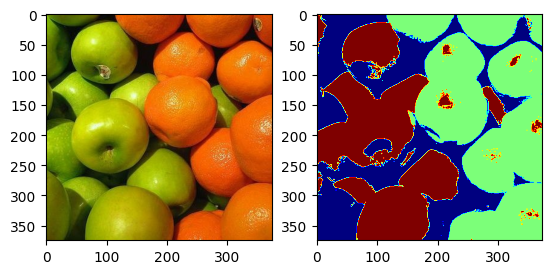

In [11]:
# show image with the assigned labels
ao_rgb = cv2.cvtColor(aao, cv2.COLOR_BGR2RGB)
plt.subplot(121), plt.imshow(ao_rgb)
plt.subplot(122), plt.imshow(np.uint8(aorsrb), cmap='jet')
plt.show()

**Q1**: Try with more clusters and less clusters. Do you think it is possible to know the number of clusters to use in advance?

What do you think are the weaknesses of this method?

define a function for kmeans and vq

In [16]:
def kmeans_vq(k,aors):
    
    codebook, _ = kmeans(np.float32(aors), k)

   
    code, _ = vq(np.float32(aors), codebook)
    
    aorsrb = np.reshape(code, (r, c))
   
    ao_rgb = cv2.cvtColor(aao, cv2.COLOR_BGR2RGB)
    plt.subplot(121), plt.imshow(ao_rgb)
    plt.subplot(122), plt.imshow(np.uint8(aorsrb), cmap='jet')
    plt.show()

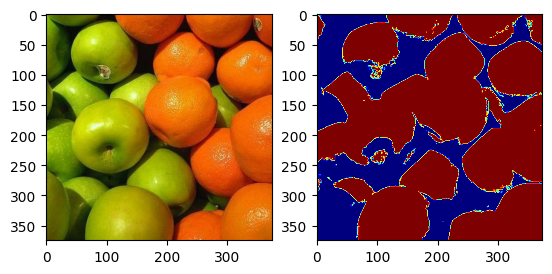

In [17]:
kmeans_vq(2,aors)

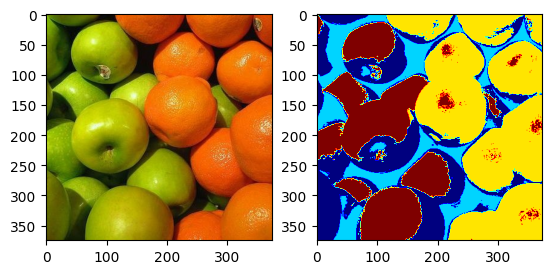

In [18]:
kmeans_vq(4,aors)

## Graph-based methods: Felzenszwalb's method and SLIC superpixels
Let's start off by loading requried libraries and an image of a particularly colorful animal...

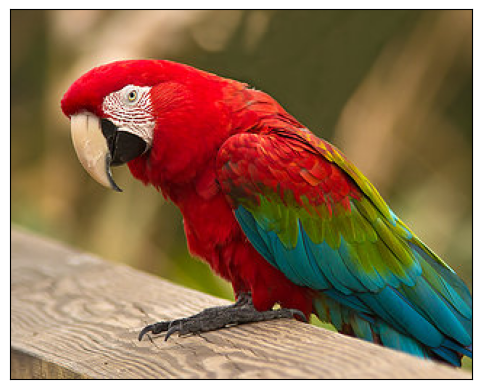

In [19]:
from skimage.segmentation import felzenszwalb, slic, random_walker
from skimage.segmentation import mark_boundaries, find_boundaries, relabel_sequential

img = cv2.imread('parrot.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

Running Felzenszwalb's algorithm on the image is really simple with scikit-image's [segmentation](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) library.

In [20]:
segments_fz = felzenszwalb(img, scale=70, sigma=0.5, min_size=150)
print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))

Felzenszwalb number of segments: 103


The array `segments_fz` contains the labeled pixels after segmentation. Visualize these segmented regions using `imshow` with a spectral colormap.

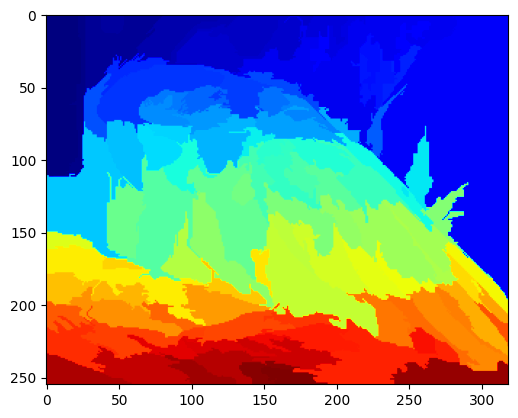

[[  0   0   0 ...  11  11  11]
 [  0   0   0 ...  11  11  11]
 [  0   0   0 ...  11  11  11]
 ...
 [ 98  98  98 ... 100 100 100]
 [ 98  98  98 ... 100 100 100]
 [ 98  98  98 ... 100 100 100]]


In [21]:
plt.imshow(segments_fz, cmap='jet')
plt.show()
print(segments_fz)

To visualize the boundaries of the segments, there's also a function `mark_boundaries` to do just that. Observe how the segments are determined, and if they make sense.

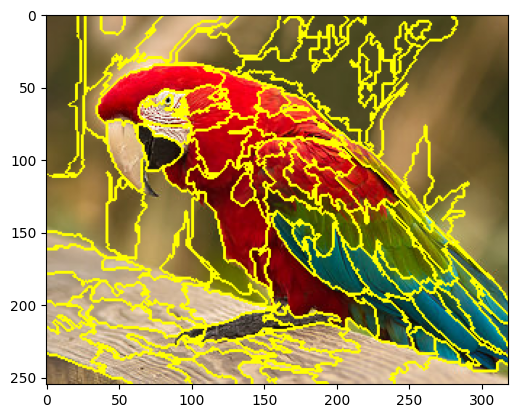

In [22]:
fz_boundaries = mark_boundaries(img, segments_fz)
plt.imshow(fz_boundaries)
plt.show()

**Q2**: Let's compute the mean colour for each segment and display the "colorized" segments (just like in the picture shown below). ![FZ-colorized parrot](parrot_felz.png)

**Hint**: A simple way to perform the colorization is using the [label2rgb](https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.label2rgb) from the skimage.color libray.

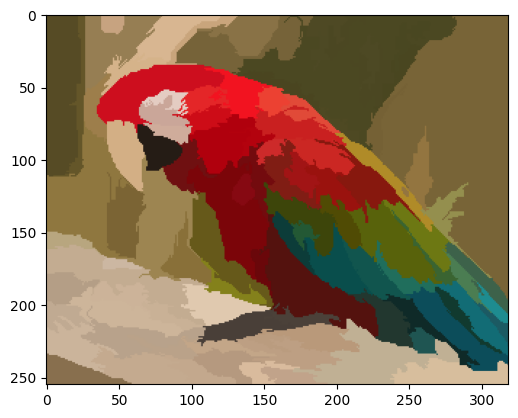

In [50]:
from skimage.color import label2rgb

bgc= np.round(np.mean(img[segments_fz==0],axis=0))
test = label2rgb(segments_fz,img,kind='avg',bg_label=0,bg_color=bgc)
plt.imshow(test)
plt.show()

In [43]:
from skimage import measure
labels = measure.label(segments_fz)
props = measure.regionprops(labels,img)
props[0].intensity_mean

array([100.52123552,  86.44787645,  41.003861  ])

**Q3**: Perform the same thing again (segment, mark boundaries, colorized) using SLIC superpixels instead.

![SLIC-colorized parrot](slic_colorized.png)

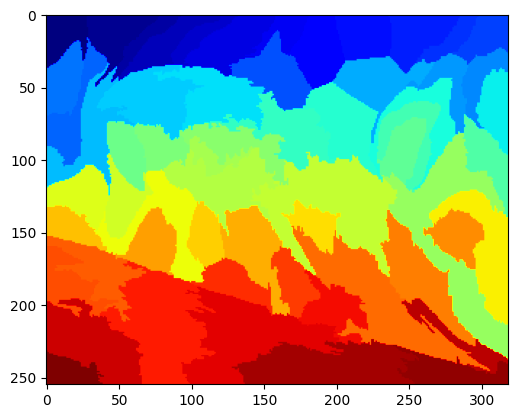

In [47]:
from skimage.segmentation import slic

slic_segments = slic(img,100,5)
plt.imshow(slic_segments,cmap='jet')
plt.show()

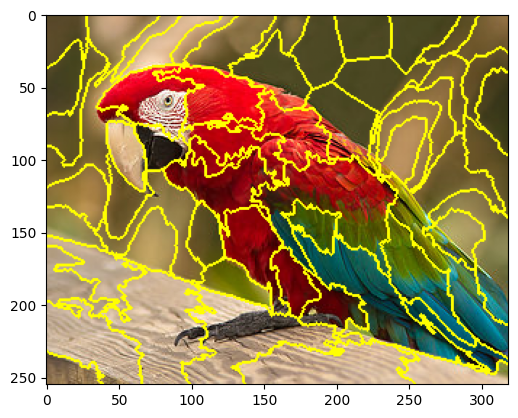

In [48]:
slic_boundaries = mark_boundaries(img, slic_segments)
plt.imshow(slic_boundaries)
plt.show()

/home/haziq/Documents/VIP/vip-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haziq/Documents/VIP/vip-env/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


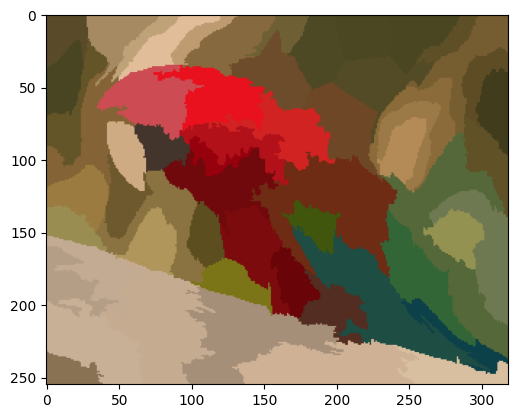

In [51]:
bgc= np.round(np.mean(img[slic_segments==0],axis=0))
slic_final = label2rgb(slic_segments,img,kind='avg',bg_label=0,bg_color=bgc)
plt.imshow(slic_final)
plt.show()

### Side track: 3D Plots

If you have completed Q2.3, you should already have your mean colours in an array.

Here's some code to plot the mean color data (RGB) on a 3D axes to visualize their locations in a 3-dimensional coordinate system. (Documentation: See [here](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#mpl_toolkits.mplot3d.Axes3D.scatter) on the 3D scatter plot)

In [52]:
from mpl_toolkits.mplot3d import Axes3D

colormeans = []
for i in range(np.max(segments_fz)+1):
    colormeans.append(np.mean(img[np.nonzero(segments_fz==i)], axis=0))

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs,  = list(zip(*colormeans))
ax.scatter(xs, ys, zs, c='b', marker='o')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline

From the scatter plot, looks like we have a pretty colour picture. There are many independent points scattered all over the RGB spectrum.

## Using segmented regions to extract features
What SLIC offers (that is better than Felzenszwalb's method can) is the uniformity of the segments. Not exactly uniform or similar in size, but *as similar or uniform as possible*. This allows us to do further things such as use them to extract features from each segment more consistently. Imagine if your segments are from very diverse sizes, even the very large segments would only be represented by the same number of features as smaller segments.

Of course, the easiest and most straightforward way of extracting "higher-level" features from each segment is by simply taking the mean colour value (just a single value) as representative of each segment.


**Q4**: Next, attempt to construct a colour histogram by binning the R, G, and B channel values into a number of bins, and concatenating them up. Determine on your own account how many bins to use for each channel. Write a function that takes in an image filename, and outputs the color histogram constructed from the segmented regions. Decide on your own if you need more input parameters to provide more options when generating the histogram. You can do this in Spyder as it can be easier to run the whole bunch of codes there.

You are now given a number of other animal images -- camel, llama, red panda, and a second parrot.

<img src="redpanda.jpg" style="display:inline; height:150px"> <img src="camel.jpg" style="display:inline; height:150px"> <img src="llama.jpg" style="display:inline; height:150px"> <img src="parrot2.jpg" style="display:inline; height:150px">

**Tip**: Considering that these different images may produce slightly different number of superpixels (although SLIC allows you to fix the number of segments, but the algorithm can only give you an approximation), it is advisable to normalize the colour histogram counts.

**Q5**: Find the nearest match to the `parrot.jpg` image from among these 4 other images. Determine which distance measure to use. (Fingers crossed that it will be `parrot2.jpg`!)

## Additional Exercises


**Q1**: **GrabCut**: Interactive Foreground Extraction

Look at the following link: [http://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html](http://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html) and have a go.

Although it says "interactive", it can be easily modified to work automatically (no humans needed).